## Описание проекта
Клиентам сотовой компании предлагается два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Изучение общей информации

In [1]:
import pandas as pd

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
inet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


- пропусков нет
- значения столбца call_date необходимо привести к формату datetime  
- значения столбца  duration необходимо округлить в бОльшую сторону, т.к тарификация поминутная  
- много значений с нулевой длительностью звонка, нужно решить, что с ними делать

In [5]:
inet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
inet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


- пропусков нет 
- столбец Unnamed: 0 повторяет индекс
- значения столбца session_date необходимо привести к формату datetime  
- значения столбца  mb_used необходимо округлить в бОльшую сторону

In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


- пропусков нет 
- значения столбца message_date необходимо привести к формату datetime  

In [9]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Здесь обрабатывать ничего не нужно, это словарь.

In [10]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Список абонентов. Солбцы с датами не нужны, так что и обрабатывать не будем. Пропущенные значения в столбце churn_date всего лишь означают, что тариф действовал на момент выгрузки.

### Подготовка данных

Приведем столбцы с датой  формату datetime.  
Солбцы с длительностью звонка и кол-вом потраченных мегабайт приведем к типу int. При этом мы получаем целую часть числа, а нам нужно округлить в бОльшую сторону, поэтому прибавим единицу. Все звонки с нулевой длительностью таким образом преобразуются в одноминутные, т.к соединение все же состоялось, а операторы это тарифицируют (вообще-то обычно не тарифицируют до 3-х секунд, но у нас в условиях это не указано).  
Добавим в датасеты столбцы с месяцем события.

In [12]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
inet['session_date'] = pd.to_datetime(inet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

calls['duration'] = calls['duration'].astype(int) + 1
inet['mb_used'] = inet['mb_used'].astype(int) + 1

calls['month'] = calls['call_date'].dt.month
inet['month'] = inet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month


Сгруппируем датасеты по абонентам и по месяцам и подсчитаем сумму использованных минут за каждый месяц для кажого абонента, суммарный интернет-траффик и количество СМС. Затем последовательно присоединим эту информацию к таблице со списком абонентов.  
Полученный результат сохраним в переменной total. Переименуем столбцы. 

In [13]:
calls_group = calls.groupby(['user_id', 'month'])['duration'].sum()
calls_group = calls_group.reset_index(level = 'month')

inet_group = inet.groupby(['user_id', 'month'])['mb_used'].sum()
inet_group = inet_group.reset_index(level = 'month')

messages_group = messages.groupby(['user_id', 'month'])['id'].count()
messages_group = messages_group.reset_index(level = 'month')

total = users.merge(calls_group, on='user_id')
total = total.merge(inet_group, on=['user_id', 'month'])
total = total.merge(messages_group, on=['user_id', 'month'])

total.rename(columns={'duration':'minutes', 'mb_used':'mbytes', 'id':'messages'}, inplace=True)

total.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes,mbytes,messages
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,164,2257,22
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,187,23262,60
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,346,14017,75
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,419,14072,81
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,479,14583,57


Посчитаем доход оператора для каждой строки датасета в цикле: для начала зададим условие для тарифа, затем внутри каждого условия сначала определим доход, как абонентскую плату, а потом последовательно прибавим к ней сумму за возможное превышение траффика по 3-м позициям: минуты, гигабайты (округляем в бОльшую сторону до 1Гб, т.к. в тарифах указана оплата за каждый начатый гигабайт) и СМС-ки.

In [14]:
for i in range(len(total)):
    if total.loc[i, 'tariff'] == 'ultra':
        total.loc[i, 'income'] = 1950
        if total.loc[i, 'minutes'] > 3000:
            total.loc[i, 'income'] += (total.loc[i, 'minutes'] - 3000) * 1
        if total.loc[i, 'mbytes'] > 30720:
            total.loc[i, 'income'] += (int((total.loc[i, 'mbytes'] - 30720) / 1024) + 1) * 150
        if total.loc[i, 'messages'] > 1000:
            total.loc[i, 'income'] += (total.loc[i, 'messages'] - 1000) * 1
    else:
        total.loc[i, 'income'] = 550
        if total.loc[i, 'minutes'] > 500:
            total.loc[i, 'income'] += (total.loc[i, 'minutes'] - 500) * 3
        if total.loc[i]['mbytes'] > 15360:
            total.loc[i, 'income'] += (int((total.loc[i, 'mbytes'] - 15360) / 1024) + 1) * 200
        if total.loc[i, 'messages'] > 50:
            total.loc[i, 'income'] += (total.loc[i, 'messages'] - 50) * 3
            
total.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes,mbytes,messages,income
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,164,2257,22,1950.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,187,23262,60,1950.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,346,14017,75,1950.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,419,14072,81,1950.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,479,14583,57,1950.0
5,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10,363,14717,73,1950.0
6,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11,344,14769,58,1950.0
7,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,341,9829,70,1950.0
8,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,118,10878,4,550.0
9,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,7,219,17615,11,1150.0


### Анализ данных

In [15]:
import numpy as np

Напишем функцию, которая считает статистики и строит гистограмму. На вход принимает тариф и название столбца, для которого считаем.

In [16]:
def stat_hist(tariff, column):
    mean = total[total['tariff']==tariff][column].mean()
    var = np.var(total[total['tariff']==tariff][column], ddof=1)
    std = np.sqrt(var)
    
    if column=='minutes':
        word = 'Минуты'
    elif column=='mbytes':
        word = 'Интернет-траффик'
    else: 
        word = 'СМС'
        
    print(word, 'для тарифа', tariff)
    print('Среднее: {:.2f}'.format(mean))
    print('Дисперсия: {:.2f}'. format(var))
    print('Стандартное отклонение: {:.2f}'.format(std))
    
    total[total['tariff']==tariff][column].hist(bins=30);

Минуты для тарифа ultra
Среднее: 572.41
Дисперсия: 102465.62
Стандартное отклонение: 320.10


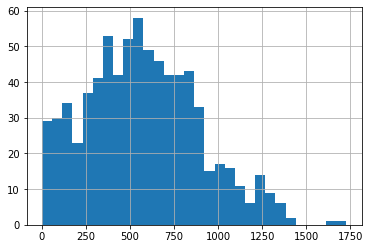

In [17]:
stat_hist('ultra', 'minutes')

Минуты для тарифа smart
Среднее: 433.10
Дисперсия: 37019.54
Стандартное отклонение: 192.40


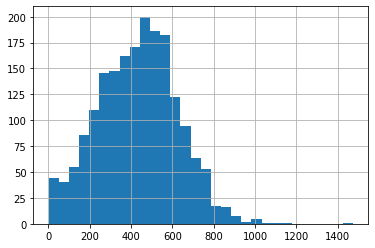

In [18]:
stat_hist('smart', 'minutes')

Распределение минут близко к нормальному. Для тарифа ultra оно смещено чуть вправо, для тарифа smart - чуть влево. Абоненты тарифа ultra в среднем разговаривают больше на 2,5 часа в месяц.

Интернет-траффик для тарифа ultra
Среднее: 19616.78
Дисперсия: 92912618.00
Стандартное отклонение: 9639.12


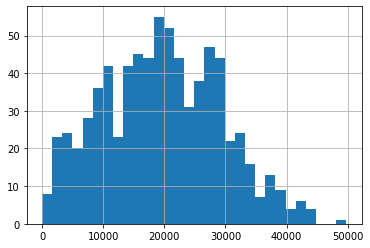

In [19]:
stat_hist('ultra', 'mbytes')

Интернет-траффик для тарифа smart
Среднее: 16274.55
Дисперсия: 33667991.81
Стандартное отклонение: 5802.41


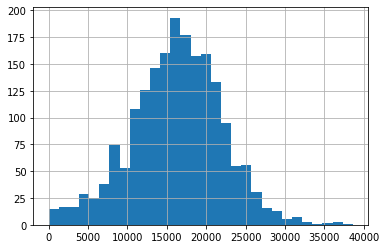

In [20]:
stat_hist('smart', 'mbytes')

Гистограммы интернет-траффика для обоих тарифов еще больше похожи на нормальное распределение. В среднем на тарифе smart абоненты потребляют около 16 Гб траффика в месяц, на тарифе ultra - около 19 Гб.

СМС для тарифа ultra
Среднее: 61.64
Дисперсия: 2008.55
Стандартное отклонение: 44.82


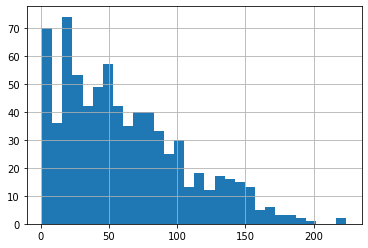

In [21]:
stat_hist('ultra', 'messages')

СМС для тарифа smart
Среднее: 38.77
Дисперсия: 718.80
Стандартное отклонение: 26.81


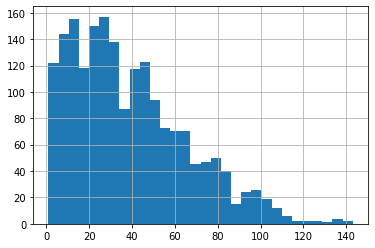

In [22]:
stat_hist('smart', 'messages')

Абонеты тарифа ultra отправляют в среднем 2 СМС-ки в день, на тарифе smart в 1.5 раза меньше. Оба графика не симметричны, бОльшая часть абонентов пишет мало сообщений (медиана меньше среднего).

### Проверка гипотез

Сформулируем нулевую гипотезу: средняя выручка для тарифов «Ультра» и «Смарт» одинакова.  
Соответственно, альтернативная гипотеза - выручка отличается. 
Для проверки гипотезы применим метод scipy.stats.ttest_ind, т.к мы измеряем параметры пользователей разных тарифов, следовательно, выборки из двух разных генеральных совокупностей. Пороговое значение выберем 5%.

In [23]:
from scipy import stats as st

In [24]:
ultra_income = total[total['tariff']=='ultra']['income']
smart_income = total[total['tariff']=='smart']['income']

print('Средняя выручка на тарифе «Ультра» : ', int(ultra_income.mean()))
print('Средняя выручка на тарифе «Смарт» : ', int(smart_income.mean()))

alpha = 0.05
results = st.ttest_ind(ultra_income, smart_income, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка на тарифе «Ультра» :  2049
Средняя выручка на тарифе «Смарт» :  1314
p-значение: 2.0016711942158686e-194
Отвергаем нулевую гипотезу


P-значение исчезающе мало, у нас есть все основания отвергнуть нулевую гипотезу, т.е с огромной вероятностью средние выручки тарифов «Ультра» и «Смарт» различаются. И по значениям среднего понятно, в какую сторону.

Проверим, различаются ли средние выручки в Москве и в регионах.  
Сформулируем нулевую гипотезу: средняя выручка в Москве и средняя выручка за её пределами равны. Соответственно, альтернативная гипотеза - выручки различаются.  
В данном случае также применим метод scipy.stats.ttest_ind(), т.к сравниваем разные выборки (Москва и регионы), а не одну и ту же до и после изменения. Порог уверенности в ложности нулевой гипотезы также 5%.

In [25]:
moscow_income = total[total['city']=='Москва']['income']
regions_income = total[total['city']!='Москва']['income']

print('Средняя выручка в Москве: ', int(moscow_income.mean()))
print('Средняя выручка в регионах: ', int(regions_income.mean()))

alpha = 0.05
results = st.ttest_ind(moscow_income, regions_income)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка в Москве:  1568
Средняя выручка в регионах:  1511
p-значение: 0.15343529869977673
Не получилось отвергнуть нулевую гипотезу


Как видим, разница в средней выручке невелика и с 15-процентной вероятностью такую разницу можно получить случайно. Это значительно выше заданного нами порогового значения, поэтому нулевую гипотезу мы отвергнуть не можем.

### Общий вывод

В задании требовалось определить, какой из двух тарифов выгоднее для сотового оператора на случайной выборке из данных о звонках, интернет-траффике и СМС-сообщениях 500 абонентов. Данные были проанализированы и сведены в общую таблицу, где для каждого абонента указано ежемесячное потребление минут, интернета и СМС, а также подсчитано, сколько денег получала компания от каждого абонента за каждый месяц 2018 года.  
На основе сводной таблицы посчитаны статистики для каждой статьи дохода и построены гистограммы распределения. Проверены гипотезы о равенстве выручки по обоим тарифам и о её независимости от локализации.  
По итогам исследования можно сделать вывод: отделу маркетинга необходимо обратить особое внимание на тариф «Ультра», т.к. данный тариф для компании значительно выгоднее. Средняя выручка в Москве и в регионах не имеет существенных различий, значит можно запускать одну федеральную рекламную компанию и не делать отдельную для Москвы.